In [1]:
import numpy as np

In [2]:
import scipy.stats as stats

def clopper_pearson_interval(successes, trials, confidence_level=0.95):
    alpha = 1 - confidence_level
    
    lower_bound = stats.beta.ppf(alpha / 2, successes, trials - successes + 1)
    upper_bound = stats.beta.ppf(1 - alpha / 2, successes + 1, trials - successes)
    
    return lower_bound, upper_bound

In [3]:
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

qp = 0
def plot_stability(file_name, window_size=30, generalize=25, color=None, label=None, axes=None, default_color=False):
    global qp
    responses = np.load(f"test_cache/permute/{file_name}.npz")["finer"][:, :950]
    trials = responses.shape[0]
    train_sum = np.sum(responses, axis=0)
    train_avg = np.average(responses, axis=0)
    lower_bounds = []
    upper_bounds = []

    for val in train_sum:
        l, u = clopper_pearson_interval(val, trials)
        lower_bounds.append(l)
        upper_bounds.append(u)

    marker = None
    if "mean" in label:
        marker = "dotted"
        alpha=1.0
    elif "max" in label:
        marker = "dashed"
        alpha = 1.0
        
    smoothed_train_avg = moving_average(train_avg, window_size)
    smoothed_lower_bounds = moving_average(lower_bounds, window_size)
    smoothed_upper_bounds = moving_average(upper_bounds, window_size)

    if default_color:
        axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg,  linestyle="-", label=label)
    
    else:
        if marker is not None:
            axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg, alpha=alpha, linestyle=marker, color=color, label=label)
            qp += 1
        else:
            axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg,  linestyle="-", color="black", label=label)



    axes.fill_between(np.array(range(len(smoothed_train_avg)))+generalize, np.clip(smoothed_lower_bounds, 0, 1),
                     np.clip(smoothed_upper_bounds, 0, 1), color='grey', alpha=0.3)

In [4]:
import matplotlib.pyplot as plt

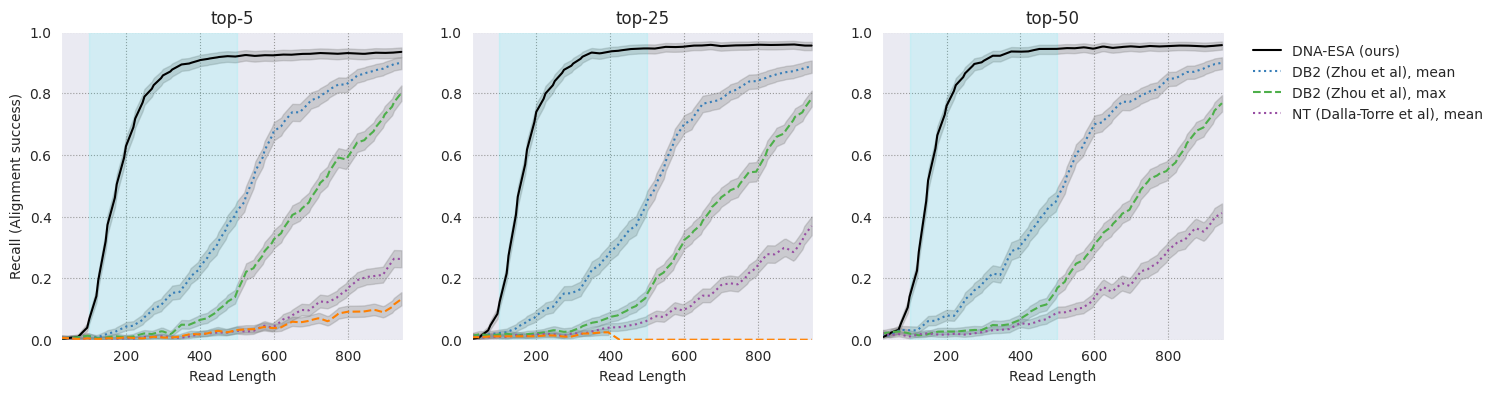

In [33]:
panes = {
    "top-5": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_5_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_5_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_5_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_5_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_5_25",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_5_25",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_5_25",
    },
    "top-25": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_25_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_25_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_25_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_25_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_25_50",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_25_25",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_25_25",
    },
    "top-50": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_50_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_50_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_50_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_50_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_50_25",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_50_25",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_50_25",
    }
}

label_vocabulary = {"DNA-ESA": "DNA-ESA (ours)", "mean-DNA2BERT": "DB2 (Zhou et al), mean", "max-DNA2BERT": "DB2 (Zhou et al), max", 
                    "mean-NucleotideTransformer": "NT (Dalla-Torre et al), mean", "max-NucleotideTransformer": "NT (Dalla-Torre et al), max",
                    "mean-HyenaDNA": "HD (Nguyen et al), mean", "max-HyenaDNA": "HD (Nguyen et al), max"}
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
colors = sns.color_palette("Set1")

color_dict = {}
for i,(k,pane) in enumerate(panes["top-5"].items()):
    color_dict[k] = colors[i]


csfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(1, 3, figsize=(15, 4))       
order = ["top-5", "top-25", "top-50"]
for i, ord_ in enumerate(order):
    for k,v in panes[ord_].items():
        try:
            plot_stability(panes[ord_][k], color=color_dict[k], label=label_vocabulary[k], axes = ax[i])
        except:
            pass
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    ax[i].fill_between([100, 500], 0, 1, color='cyan', alpha=0.1)

    ax[i].set_xlabel("Read Length")
    if i == 0:
        ax[i].set_ylabel("Recall (Alignment success)")
    # ax[i].grid(which="both")
    ax[i].set_xlim([25, 950])
    ax[i].set_ylim([0,1])
    ax[i].set_title(ord_)
    # if i == len(order) - 1:  # Only for the last subplot
    #     ax[i].legend(fontsize="8", loc="lower right", bbox_to_anchor=(1, 1))
    # else:
    #     ax[i].legend().set_visible(False)  # Hide legend for other subplots
        
    # ax[i].legend(fontsize="8", loc="upper left")
fig.subplots_adjust(right=0.90)  # Adjust the value as needed

# Create a legend outside the subplots
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, facecolor='white')
# plt.legend()
output_file = 'figures/baselines.png'
plt.savefig(output_file, dpi=500, bbox_inches='tight', format="png")
plt.show()

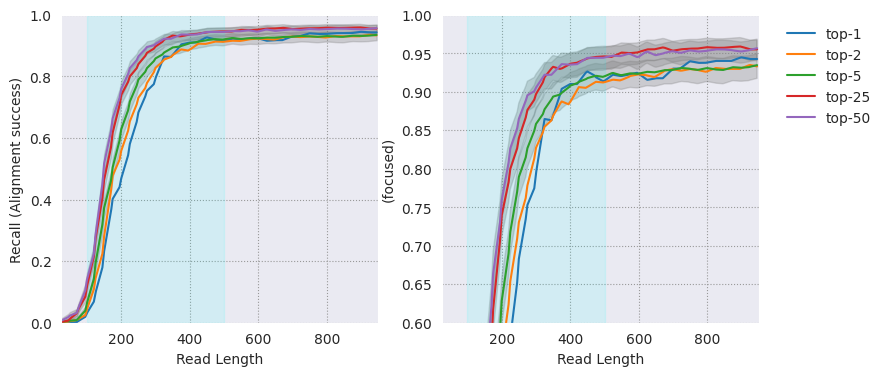

In [32]:
panes = {
    "top-1": "run_config-trained-all-longer-all_random_sub_1000_1_25",
    "top-2": "run_config-trained-all-longer-all_random_sub_1000_2_25",
    "top-5": "run_config-trained-all-longer-all_random_sub_1000_5_25",
    "top-25": "run_config-trained-all-longer-all_random_sub_1000_25_25",
    "top-50": "run_config-trained-all-longer-all_random_sub_1000_50_25"
}

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
csfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(1, 2, figsize=(9, 4))   

order = ["top-1", "top-2", "top-5", "top-25", "top-50"]
for ax_ in ax:

    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    for i, ord_ in enumerate(order):
        try:
            plot_stability(panes[ord_], label=ord_, axes = ax_, default_color = True)
        except:
            pass

ax[0].set_xlabel("Read Length")        
        
ax[0].set_xlim([25,950])
ax[0].set_ylim([0,1])

ax[0].set_ylabel("Recall (Alignment success)")
ax[0].fill_between([100, 500], 0, 1, color='cyan', alpha=0.1)
# ax[0].legend(fontsize="10", loc="lower right")

ax[1].set_xlabel("Read Length")        
        
ax[1].set_xlim([25,950])
ax[1].set_ylim([0.6,1])
ax[1].set_ylabel("(focused)")

ax[1].fill_between([100, 500], 0, 1, color='cyan', alpha=0.1)
# ax[1].legend(fontsize="10", loc="lower right")

fig.subplots_adjust(right=0.90)  # Adjust the value as needed

# Create a legend outside the subplots
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, facecolor='white')

output_file = 'figures/topk.png'
plt.savefig(output_file, dpi=500, bbox_inches='tight', format="png")
plt.show()